In [2]:
from datetime import datetime, timedelta
import time

import requests, pandas, lxml
from lxml import html

import numpy as np
import matplotlib.pyplot as plt

In [3]:
def format_date(date_datetime):
    date_timetuple = date_datetime.timetuple()
    date_mktime = time.mktime(date_timetuple)
    date_int = int(date_mktime)
    date_str = str(date_int)
    return date_str


def subdomain(symbol, start, end, filter='history'):
    subdoma="/quote/{0}/history?period1={1}&period2={2}&interval=1d&filter={3}&frequency=1d"
    subdomain = subdoma.format(symbol, start, end, filter)
    return subdomain


def header_function(subdomain):
    hdrs = {"authority": "finance.yahoo.com",
            "method": "GET",
            "path": subdomain,
            "scheme": "https",
            "accept": "text/html",
            "accept-encoding": "gzip, deflate, br",
            "accept-language": "en-US,en;q=0.9",
            "cache-control": "no-cache",
            "dnt": "1",
            "pragma": "no-cache",
            "sec-fetch-mode": "navigate",
            "sec-fetch-site": "same-origin",
            "sec-fetch-user": "?1",
            "upgrade-insecure-requests": "1",
            "user-agent": "Mozilla/5.0 (Windows NT 10.0; Win64)"}
    return hdrs


def scrape_page(url, header):
    page = requests.get(url, headers=header)
    element_html = html.fromstring(page.content)
    table = element_html.xpath('//table')
    table_tree = lxml.etree.tostring(table[0], method='xml')
    panda = pandas.read_html(table_tree)
    return panda

In [4]:
symbol = 'BB'

dt_start = datetime.today() - timedelta(days=365)
dt_end = datetime.today()

start = format_date(dt_start)
end = format_date(dt_end)

sub = subdomain(symbol, start, end)
header = header_function(sub)

base_url = 'https://finance.yahoo.com'
url = base_url + sub
price_history = scrape_page(url, header)

In [5]:
price_history

[                                                  Date  \
 0                                         May 27, 2021   
 1                                         May 26, 2021   
 2                                         May 25, 2021   
 3                                         May 24, 2021   
 4                                         May 21, 2021   
 ..                                                 ...   
 96                                        Jan 08, 2021   
 97                                        Jan 07, 2021   
 98                                        Jan 06, 2021   
 99                                        Jan 05, 2021   
 100  *Close price adjusted for splits.**Adjusted cl...   
 
                                                   Open  \
 0                                                 9.70   
 1                                                 8.79   
 2                                                 8.64   
 3                                                 8.5

In [6]:
price_df = price_history[0]

In [48]:
price_df.

Index(['Date', 'Open', 'High', 'Low', 'Close*', 'Adj Close**', 'Volume'], dtype='object')

In [15]:
price_df.columns

Index(['Date', 'Open', 'High', 'Low', 'Close*', 'Adj Close**', 'Volume'], dtype='object')

In [7]:
#Get close price of each day
close_price = np.flip(np.array(price_df['Adj Close**'][0:100]).astype('float'))
print(close_price)

[ 6.77  6.71  7.06  7.56  7.65  7.63  7.44  9.11  9.84 12.35 12.79 12.85
 14.04 18.03 18.92 25.1  14.65 14.1  14.63 11.55 12.   12.15 13.23 13.76
 13.43 13.1  12.46 13.04 12.21 11.32 10.94 10.9  10.68 10.4  11.32 10.58
 10.05 10.91 10.5  10.15  9.84  9.45  9.75 10.45 10.34 10.7  11.85 11.68
 11.46 11.6  10.76 10.95 10.71 10.07  9.58  9.88  9.63  9.2   9.34  8.43
  8.6   9.3   8.99  8.91  9.44  9.13  9.03  9.1   9.    8.77  8.7   8.62
  8.21  8.66  8.64  8.85  9.09  9.29  9.3   9.06  8.83  8.61  8.36  8.22
  8.15  8.48  8.13  8.3   7.95  7.94  8.44  8.49  8.77  8.54  8.78  8.52
  8.62  8.59  9.44  9.97]


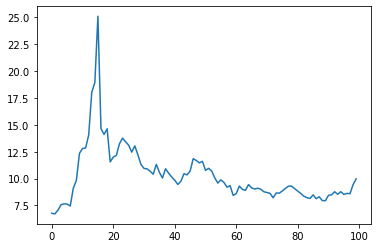

In [8]:
plt.plot(close_price)
plt.show()

In [9]:
def ta_SimpleMovingAverage(data, period=5, order='new2old'):
    if order=='old2new':
        data = np.flip(data)
    elif order=='new2old':
        pass
    else:
        print("Argumnent 'order' invalid")
        return None
    
    sma = []
    
    for i in range(0, len(data)-period+1):
        avg = np.mean(data[i:i+period])
        sma.append(avg)
        
    sma = np.array(sma)
    
    if order=='old2new':
        sma = np.flip(sma)
        
    return sma
    
    

In [10]:
period_N = 10
close_price_sma = ta_SimpleMovingAverage(close_price, period=period_N, order='old2new')

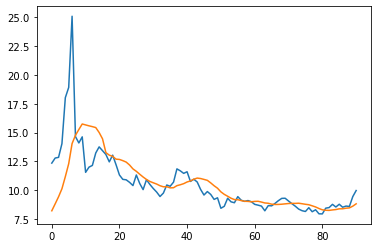

In [11]:
plt.plot(close_price[period_N-1:])
plt.plot(close_price_sma)
plt.show()

In [23]:
def ta_ExponentialMovingAverage(data, smooth=2.0, period=12, order='old2new'):
    if order=='new2old':
        data = np.flip(data)
    elif order=='old2new':
        pass
    else:
        print("Argumnent 'order' invalid")
        return None
    
    ema = []
    k = smooth/(1+period)
    eavg_y = np.mean(data[0:period])  #initial EMA
    
    for i in range(period, len(data)):
        eavg = data[i]*k + eavg_y*(1-k)
        eavg_y = eavg
        ema.append(eavg)
        
    ema = np.array(ema)
        
    if order=='new2old':
        ema = np.flip(ema)
    
    return ema


    

In [24]:
close_price_ema = ta_ExponentialMovingAverage(close_price, period=period_N)

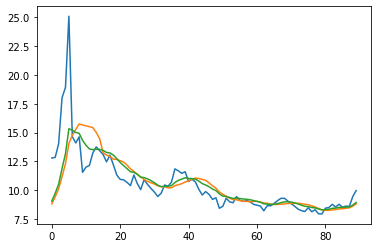

In [26]:
plt.plot(close_price[period_N:])
plt.plot(close_price_sma[1:])
plt.plot(close_price_ema)
plt.show()

In [32]:
def ta_MACD(data, order='old2new'):
    if order=='new2old':
        data = np.flip(data)
    elif order=='old2new':
        pass
    else:
        print("Argumnent 'order' invalid")
        return None
    
    ema_12 = ta_ExponentialMovingAverage(data, period=12)
    ema_26 = ta_ExponentialMovingAverage(data, period=26)
    macd = ema_12[14:] - ema_26
    
    if order=='new2old':
        macd = np.flip(macd)
        
    return macd, ema_12, ema_26
    
    

In [33]:
cp_macd, cp_ema_12, cp_ema_26  = ta_MACD(close_price)

In [30]:
len(close_price_macd)

74

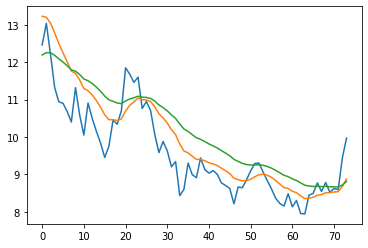

In [35]:
plt.plot(close_price[26:])
plt.plot(cp_ema_12[14:])
plt.plot(cp_ema_26)
plt.show()

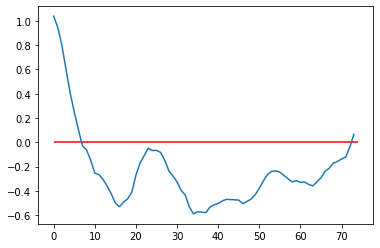

In [38]:
plt.hlines(0, 0, len(cp_macd), color='r')
plt.plot(cp_macd)
plt.show()

In [15]:
print(table[0][0][0][0][0])

<Element span at 0x7fd369f72548>


In [16]:
#turn the table element into byte string
table_tree = lxml.etree.tostring(table[0], method='xml')

In [17]:
table_tree

b'<table class="W(100%) M(0)" data-test="historical-prices" data-reactid="33"><thead data-reactid="34"><tr class="C($tertiaryColor) Fz(xs) Ta(end)" data-reactid="35"><th class="Ta(start) W(100px) Fw(400) Py(6px)" data-reactid="36"><span data-reactid="37">Date</span></th><th class="Fw(400) Py(6px)" data-reactid="38"><span data-reactid="39">Open</span></th><th class="Fw(400) Py(6px)" data-reactid="40"><span data-reactid="41">High</span></th><th class="Fw(400) Py(6px)" data-reactid="42"><span data-reactid="43">Low</span></th><th class="Fw(400) Py(6px)" data-reactid="44"><span data-reactid="45">Close*</span></th><th class="Fw(400) Py(6px)" data-reactid="46"><span data-reactid="47">Adj Close**</span></th><th class="Fw(400) Py(6px)" data-reactid="48"><span data-reactid="49">Volume</span></th></tr></thead><tbody data-reactid="50"><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)" data-reactid="51"><td class="Py(10px) Ta(start) Pend(10px)" data-reactid="52"><span data-reactid="53">May 

In [18]:
panda = pandas.read_html(table_tree)

In [20]:
panda

[                                                  Date  \
 0                                         May 21, 2021   
 1                                         May 20, 2021   
 2                                         May 19, 2021   
 3                                         May 18, 2021   
 4                                         May 17, 2021   
 ..                                                 ...   
 96                                        Jan 04, 2021   
 97                                        Dec 31, 2020   
 98                                        Dec 30, 2020   
 99                                        Dec 29, 2020   
 100  *Close price adjusted for splits.**Adjusted cl...   
 
                                                   Open  \
 0                                                 8.84   
 1                                                 8.64   
 2                                                 8.44   
 3                                                 8.5